<a href="https://colab.research.google.com/github/ducpc99/CNNs_for_Text_Classification/blob/main/CNNs_for_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import kagglehub
from transformers import BertTokenizer
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(42)
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
df = pd.read_csv(f'{path}/IMDB Dataset.csv')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

100%|██████████| 25.7M/25.7M [00:00<00:00, 77.6MB/s]

Extracting files...



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=200):
        self.texts = texts
        self.labels = [1 if label == 'positive' else 0 for label in labels]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze(0)

        return input_ids, torch.tensor(label, dtype=torch.long)

Define CNN Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, padding_idx=0):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                     out_channels=n_filters,
                     kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        text = torch.clamp(text, min=0, max=self.embedding.num_embeddings - 1)

        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim=1))

        return self.fc(cat)

Train the Model

In [ ]:
def train(model, trainloader, criterion, optimizer, epochs, device):
    model = model.to(device)
    best_loss = float('inf')
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        total_batches = len(trainloader)

        print(f'\nEpoch {epoch+1}/{epochs}')
        print('-' * 60)

        for i, (inputs, labels) in enumerate(trainloader):
            try:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                if (i + 1) % 50 == 0 or (i + 1) == total_batches:
                    avg_loss = running_loss / (i + 1)
                    accuracy = 100 * correct / total
                    print(f'Batch [{i+1}/{total_batches}] | '
                          f'Loss: {avg_loss:.3f} | '
                          f'Accuracy: {accuracy:.2f}%')

            except RuntimeError as e:
                print(f"Error in batch {i}: {str(e)}")
                continue

        epoch_loss = running_loss / total_batches
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)

        print(f'\nEpoch {epoch+1} Summary:')
        print(f'Average Loss: {epoch_loss:.3f}')
        print(f'Accuracy: {epoch_accuracy:.2f}%')
        print('-' * 60)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), 'best_model.pt')

    return train_losses

Evaluate the Model

In [ ]:
def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in testloader:
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            except RuntimeError as e:
                print(f"Error during evaluation: {str(e)}")
                continue

    if total == 0:
        print("No valid batches found during evaluation")
        return None

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(testloader)

    from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels,
                                                             all_predictions,
                                                             average='binary')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print('\nTest Results:')
    print('-' * 60)
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('\nConfusion Matrix:')
    print(conf_matrix)

    return {
        'accuracy': accuracy,
        'loss': avg_loss,
        'predictions': all_predictions,
        'true_labels': all_labels
    }


Train and Test the Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)

train_texts = train_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

train_texts, test_texts = train_texts.tolist(), test_texts.tolist()
train_labels, test_labels = train_labels.tolist(), test_labels.tolist()

train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Using device: cuda


Starting training...

Epoch 1/5
------------------------------------------------------------
Batch [50/2500] | Loss: 0.843 | Accuracy: 52.88%
Batch [100/2500] | Loss: 0.824 | Accuracy: 54.38%
Batch [150/2500] | Loss: 0.801 | Accuracy: 54.75%
Batch [200/2500] | Loss: 0.783 | Accuracy: 55.69%
Batch [250/2500] | Loss: 0.770 | Accuracy: 56.38%
Batch [300/2500] | Loss: 0.754 | Accuracy: 57.17%
Batch [350/2500] | Loss: 0.746 | Accuracy: 57.84%
Batch [400/2500] | Loss: 0.740 | Accuracy: 58.22%
Batch [450/2500] | Loss: 0.732 | Accuracy: 58.71%
Batch [500/2500] | Loss: 0.724 | Accuracy: 59.05%
Batch [550/2500] | Loss: 0.716 | Accuracy: 59.57%
Batch [600/2500] | Loss: 0.709 | Accuracy: 60.04%
Batch [650/2500] | Loss: 0.703 | Accuracy: 60.50%
Batch [700/2500] | Loss: 0.694 | Accuracy: 61.12%
Batch [750/2500] | Loss: 0.689 | Accuracy: 61.58%
Batch [800/2500] | Loss: 0.684 | Accuracy: 61.84%
Batch [850/2500] | Loss: 0.679 | Accuracy: 62.27%
Batch [900/2500] | Loss: 0.676 | Accuracy: 62.53%
Batch [9

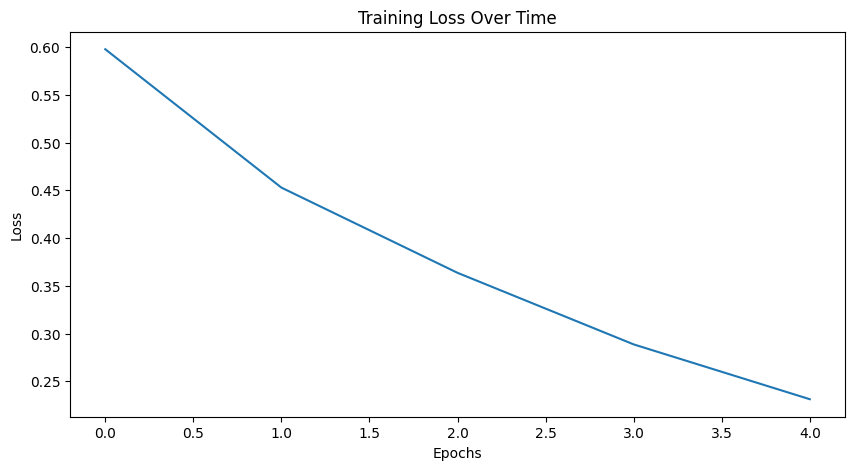

In [ ]:
model = CNN(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=100,
    n_filters=100,
    filter_sizes=[3,4,5],
    output_dim=2,
    dropout=0.5,
    padding_idx=tokenizer.pad_token_id
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)

print("Starting training...")
train_losses = train(model, train_loader, criterion, optimizer, epochs=5, device=device)
results = evaluate(model, test_loader, device)

if results:
    print(f"Final Test Accuracy: {results['accuracy']:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
def test_custom_statement(model, tokenizer, statement, device):
    model.eval()
    encoding = tokenizer.encode_plus(
        statement,
        add_special_tokens=True,
        max_length=200,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        _, predicted = torch.max(outputs, 1)
    sentiment = "positive" if predicted.item() == 1 else "negative"
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    confidence = probabilities.max().item() * 100

    return sentiment, confidence

# Test the model on a custom statement
test_statement = "This movie was absolutely the shit! The acting was superb and the story kept me engaged throughout."
sentiment, confidence = test_custom_statement(model, tokenizer, test_statement, device)
print(f"\nTest statement: {test_statement}")
print(f"Predicted sentiment: {sentiment}")
print(f"Confidence: {confidence:.2f}%")


Test statement: This movie was absolutely the shit! The acting was superb and the story kept me engaged throughout.
Predicted sentiment: positive
Confidence: 69.86%


Tuning


Starting training...

Epoch 1/10
------------------------------------------------------------
Batch [50/2500] | Loss: 1.716 | Accuracy: 52.38%
Batch [100/2500] | Loss: 2.341 | Accuracy: 51.62%
Batch [150/2500] | Loss: 2.639 | Accuracy: 52.38%
Batch [200/2500] | Loss: 2.859 | Accuracy: 53.03%
Batch [250/2500] | Loss: 2.767 | Accuracy: 54.20%
Batch [300/2500] | Loss: 2.650 | Accuracy: 55.04%
Batch [350/2500] | Loss: 2.548 | Accuracy: 55.52%
Batch [400/2500] | Loss: 2.715 | Accuracy: 55.39%
Batch [450/2500] | Loss: 2.926 | Accuracy: 55.64%
Batch [500/2500] | Loss: 3.081 | Accuracy: 55.71%
Batch [550/2500] | Loss: 3.330 | Accuracy: 55.77%
Batch [600/2500] | Loss: 3.658 | Accuracy: 55.73%
Batch [650/2500] | Loss: 4.239 | Accuracy: 55.48%
Batch [700/2500] | Loss: 4.371 | Accuracy: 55.92%
Batch [750/2500] | Loss: 4.570 | Accuracy: 56.11%
Batch [800/2500] | Loss: 5.126 | Accuracy: 56.02%
Batch [850/2500] | Loss: 5.579 | Accuracy: 56.10%
Batch [900/2500] | Loss: 6.044 | Accuracy: 56.12%
Batch [

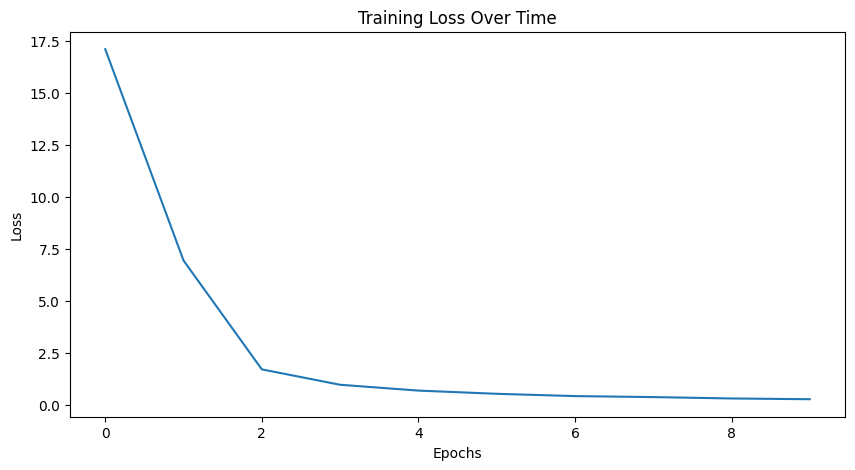

In [ ]:
model = CNN(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=100,
    n_filters=100,
    filter_sizes=[3,4,5],
    output_dim=2,
    dropout=0.2, # Tuning dropout
    padding_idx=tokenizer.pad_token_id
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # Tuning learning rate, optimizer

model = model.to(device)

print("Starting training...")
train_losses = train(model, train_loader, criterion, optimizer, epochs=10, device=device) # Tuning epoch
results = evaluate(model, test_loader, device)

if results:
    print(f"Final Test Accuracy: {results['accuracy']:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
sentiment, confidence = test_custom_statement(model, tokenizer, test_statement, device)
print(f"\nTest statement: {test_statement}")
print(f"Predicted sentiment: {sentiment}")
print(f"Confidence: {confidence:.2f}%")


Test statement: This movie was absolutely the shit! The acting was superb and the story kept me engaged throughout.
Predicted sentiment: positive
Confidence: 96.67%
